In [54]:
from google.colab import drive
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from scipy.stats import kendalltau, spearmanr
from statsmodels.tsa.stattools import adfuller
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan


In [55]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
base_project_level_dataset = 'open_source_projects_summary.csv'
base_file_level_dataset = 'file_level_metrics.csv'
dataset_updated_with_organizations = 'project_level_aggregated_data.csv'
dataset_updated_and_filtered_for_thesis = 'filtered_repositories_data.csv'

if os.path.isfile(base_project_level_dataset and base_file_level_dataset and dataset_updated_with_organizations and dataset_updated_and_filtered_for_thesis):
    print("Files found!")
else:
    print("Files not found.")



Files found!


In [57]:
main_df = pd.read_csv(dataset_updated_with_organizations)

mini_df = pd.read_csv(dataset_updated_and_filtered_for_thesis)
merged_df = pd.read_csv(dataset_updated_and_filtered_for_thesis)

mini_df[['organization', 'project_name']] = mini_df['full_name'].str.split('/', expand=True)

merged_df = pd.merge(mini_df, main_df, on=['organization', 'project_name'])

merged_df.drop(columns=['full_name'], inplace=True)

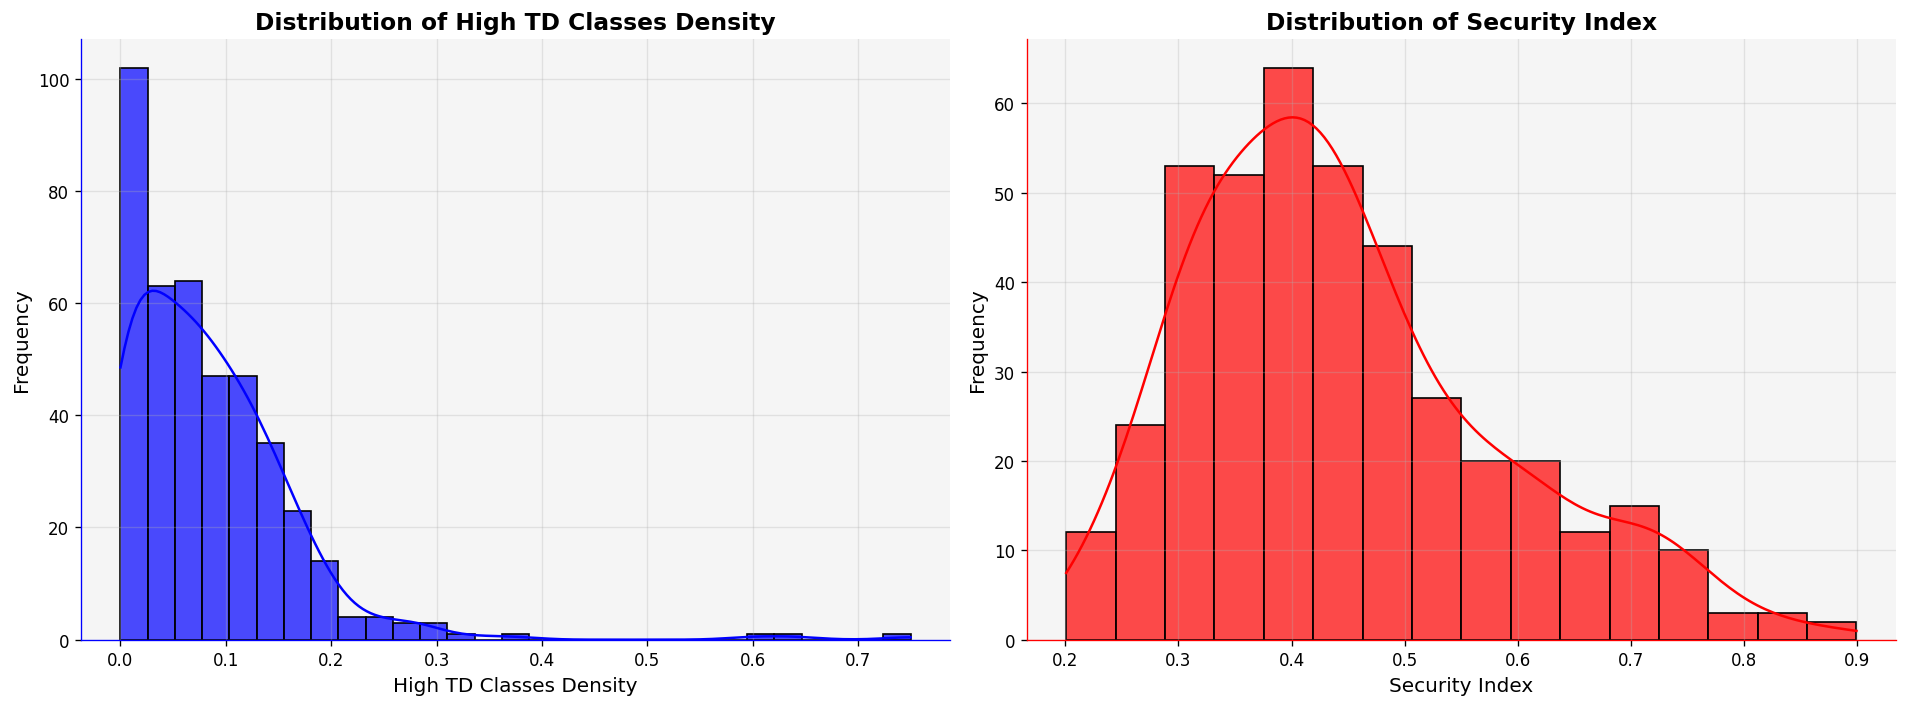

Normality Tests:

Shapiro-Wilk Test for High TD Classes Density:
Statistic: 0.7784, p-value: 0.0000
High TD Classes Density does not follow a normal distribution (p ≤ 0.05)

Shapiro-Wilk Test for Security Index:
Statistic: 0.9521, p-value: 0.0000
Security Index does not follow a normal distribution (p ≤ 0.05)

Correlation Analysis:

Pearson Correlation Matrix:
                         high_td_classes_density  security_index
high_td_classes_density                 1.000000       -0.178199
security_index                         -0.178199        1.000000

Spearman Correlation Matrix:
                         high_td_classes_density  security_index
high_td_classes_density                 1.000000       -0.277328
security_index                         -0.277328        1.000000


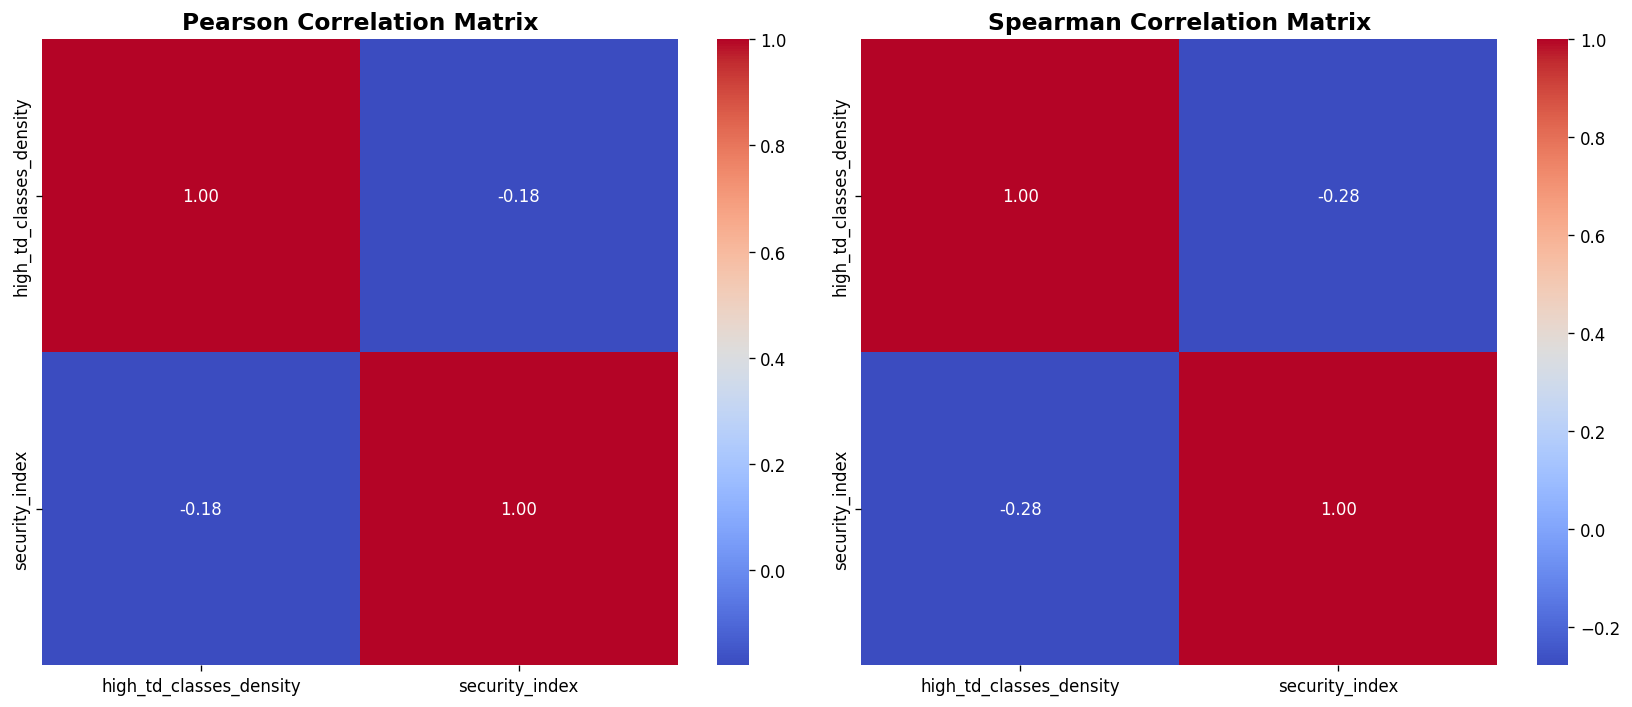

In [58]:
selected_columns = ['high_td_classes_density', 'security_index']
selected_df = merged_df[selected_columns].dropna()

def fancy_plot(ax, title, xlabel='', ylabel='', color='blue'):
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    sns.despine(ax=ax, top=True, right=True)
    ax.grid(visible=True, alpha=0.3)
    ax.set_facecolor('#f5f5f5')
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=120)

sns.histplot(selected_df['high_td_classes_density'], kde=True, ax=axes[0], color='blue', edgecolor='black', alpha=0.7)
fancy_plot(
    axes[0],
    title='Distribution of High TD Classes Density',
    xlabel='High TD Classes Density',
    ylabel='Frequency',
    color='blue'
)

sns.histplot(selected_df['security_index'], kde=True, ax=axes[1], color='red', edgecolor='black', alpha=0.7)
fancy_plot(
    axes[1],
    title='Distribution of Security Index',
    xlabel='Security Index',
    ylabel='Frequency',
    color='red'
)

plt.tight_layout()
plt.show()

def test_normality(data, name):
    stat, p_value = stats.shapiro(data)
    print(f'\nShapiro-Wilk Test for {name}:')
    print(f'Statistic: {stat:.4f}, p-value: {p_value:.4f}')
    if p_value > 0.05:
        print(f'{name} likely follows a normal distribution (p > 0.05)')
    else:
        print(f'{name} does not follow a normal distribution (p ≤ 0.05)')

print("Normality Tests:")
test_normality(selected_df['high_td_classes_density'], 'High TD Classes Density')
test_normality(selected_df['security_index'], 'Security Index')

print("\nCorrelation Analysis:")
pearson_corr = selected_df.corr(method='pearson')
spearman_corr = selected_df.corr(method='spearman')

print("\nPearson Correlation Matrix:")
print(pearson_corr)

print("\nSpearman Correlation Matrix:")
print(spearman_corr)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=120)

sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix', fontsize=14, weight='bold')

sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()


In [59]:
def calculate_confidence_interval(data, confidence=0.95):
  mean = np.mean(data)
  std_error = stats.sem(data)
  margin_of_error = std_error * stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
  lower_bound = mean - margin_of_error
  upper_bound = mean + margin_of_error
  return lower_bound, upper_bound

security_index_ci = calculate_confidence_interval(selected_df['security_index'])
high_td_classes_density_ci = calculate_confidence_interval(selected_df['high_td_classes_density'])

print("Confidence Interval for Security Index:", security_index_ci)
print("Confidence Interval for High TD Classes Density:", high_td_classes_density_ci)


Confidence Interval for Security Index: (0.433000363183459, 0.4592885392339323)
Confidence Interval for High TD Classes Density: (0.07565406948305506, 0.09165141010100289)


In [60]:
td_columns = [
    'cbo', 'wmc', 'dit', 'rfc', 'lcom', 'npm', 'fanin', 'fanout',
    'noc', 'ncloc', 'duplicated_lines', 'duplicated_lines_density',
    'total_lines', 'high_td_classes', 'high_td_classes_density'
]

security_columns = [
    'sam_resource_handling_eval', 'sam_resource_handling_density',
    'sam_assignment_eval', 'sam_assignment_density',
    'sam_exception_handling_eval', 'sam_exception_handling_density',
    'sam_misused_functionality_eval', 'sam_misused_functionality_density',
    'sam_synchronization_eval', 'sam_synchronization_density',
    'sam_null_pointer_eval', 'sam_null_pointer_density',
    'sam_logging_eval', 'sam_logging_density', 'sam_cohesion_eval',
    'sam_cohesion_norm', 'sam_coupling_eval', 'sam_coupling_norm',
    'sam_complexity_eval', 'sam_complexity_norm', 'sam_encapsulation_eval',
    'sam_encapsulation_norm', 'sam_confidentiality_eval', 'sam_integrity_eval',
    'sam_availability_eval', 'sam_total_issues', 'security_index'
]

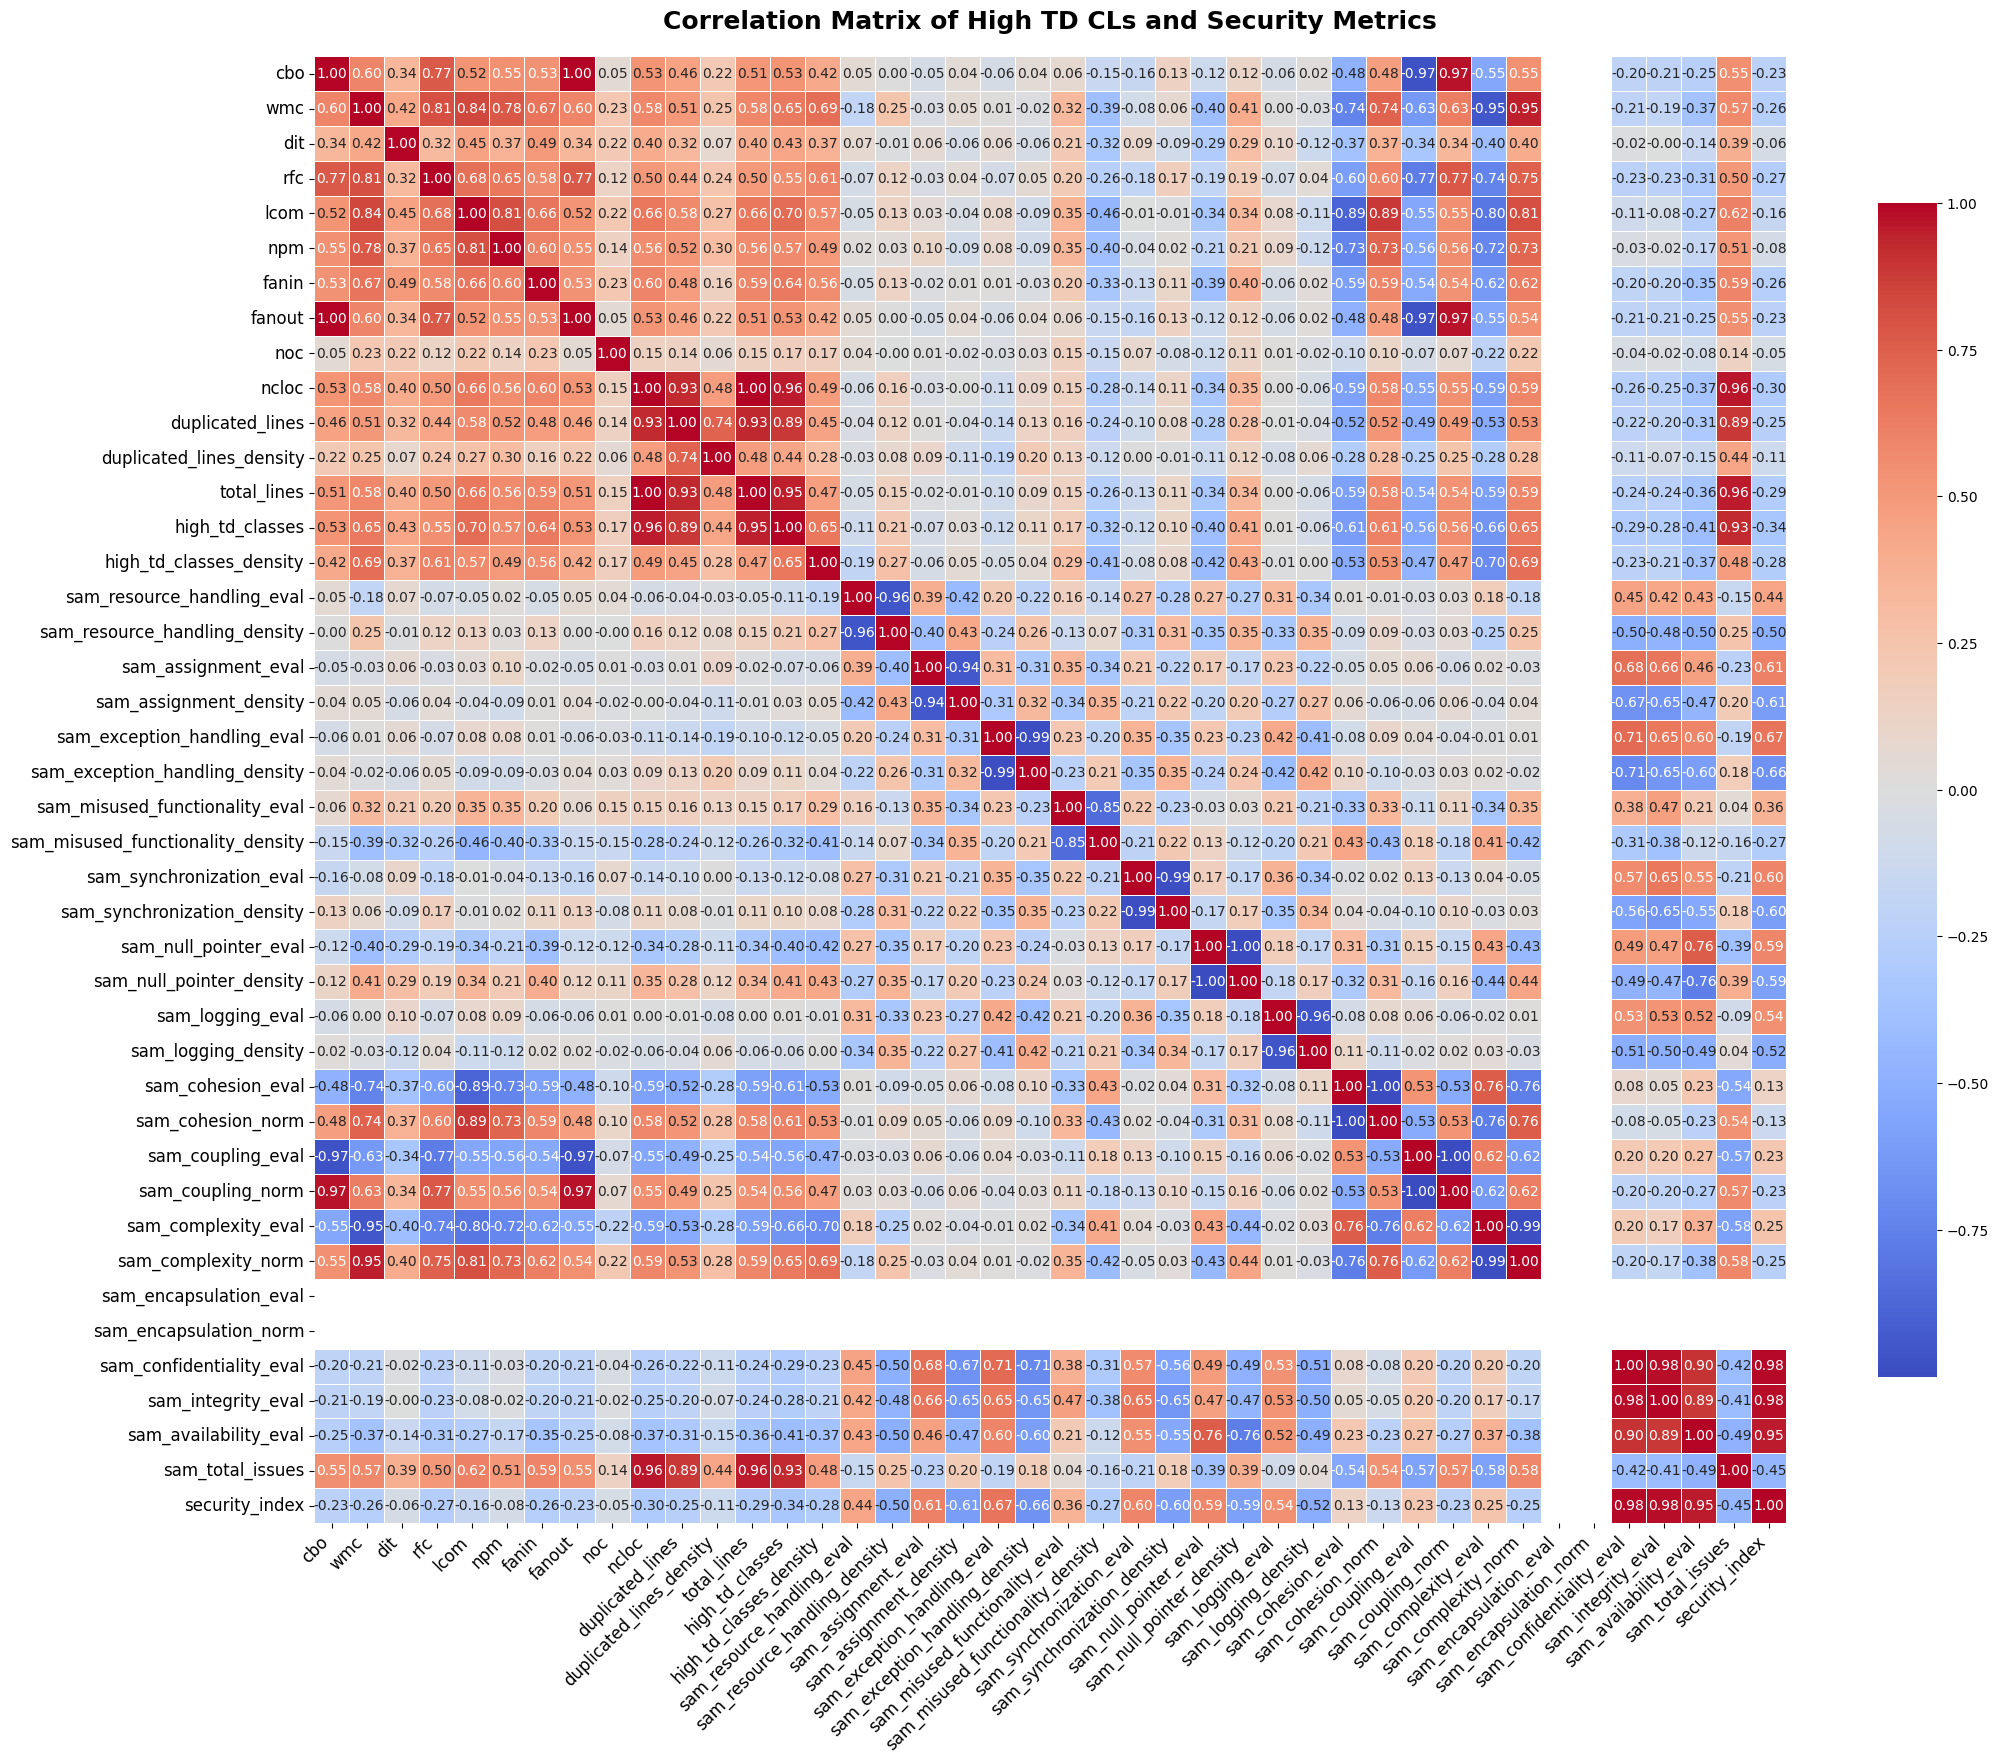

In [61]:
corr_matrix = merged_df[td_columns + security_columns].corr(method="spearman")

plt.figure(figsize=(22, 18))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8, "aspect": 20},
)

plt.title('Correlation Matrix of High TD CLs and Security Metrics', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout(pad=2.0)

plt.show()

<ipython-input-62-1d747b2d07eb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=security_index_correlations.values, y=security_index_correlations.index, palette="coolwarm")


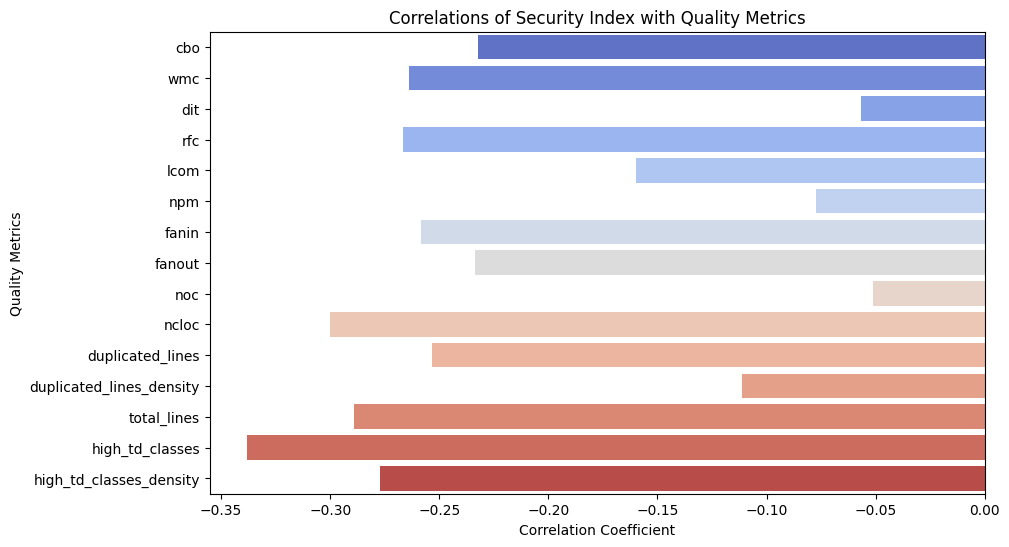

cbo                        -0.232461
wmc                        -0.263928
dit                        -0.056891
rfc                        -0.266727
lcom                       -0.160017
npm                        -0.077162
fanin                      -0.258482
fanout                     -0.233839
noc                        -0.050957
ncloc                      -0.299890
duplicated_lines           -0.253187
duplicated_lines_density   -0.111056
total_lines                -0.289016
high_td_classes            -0.338341
high_td_classes_density    -0.277328
Name: security_index, dtype: float64


In [62]:
combined_df = merged_df[security_columns + td_columns]
combined_corr_matrix = combined_df.corr(method='spearman')
security_index_correlations = combined_corr_matrix.loc['security_index', td_columns]

plt.figure(figsize=(10, 6))
sns.barplot(x=security_index_correlations.values, y=security_index_correlations.index, palette="coolwarm")
plt.title("Correlations of Security Index with Quality Metrics")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Quality Metrics")
plt.show()

print(security_index_correlations)

Subset Correlation Matrix:
                                   high_td_classes_density
sam_resource_handling_eval                       -0.188695
sam_resource_handling_density                     0.273911
sam_assignment_eval                              -0.056788
sam_assignment_density                            0.051143
sam_exception_handling_eval                      -0.049725
sam_exception_handling_density                    0.039499
sam_misused_functionality_eval                    0.286679
sam_misused_functionality_density                -0.405692
sam_synchronization_eval                         -0.075775
sam_synchronization_density                       0.078163
sam_null_pointer_eval                            -0.422945
sam_null_pointer_density                          0.425547
sam_logging_eval                                 -0.012742
sam_logging_density                               0.001145
sam_cohesion_eval                                -0.527716
sam_cohesion_norm            

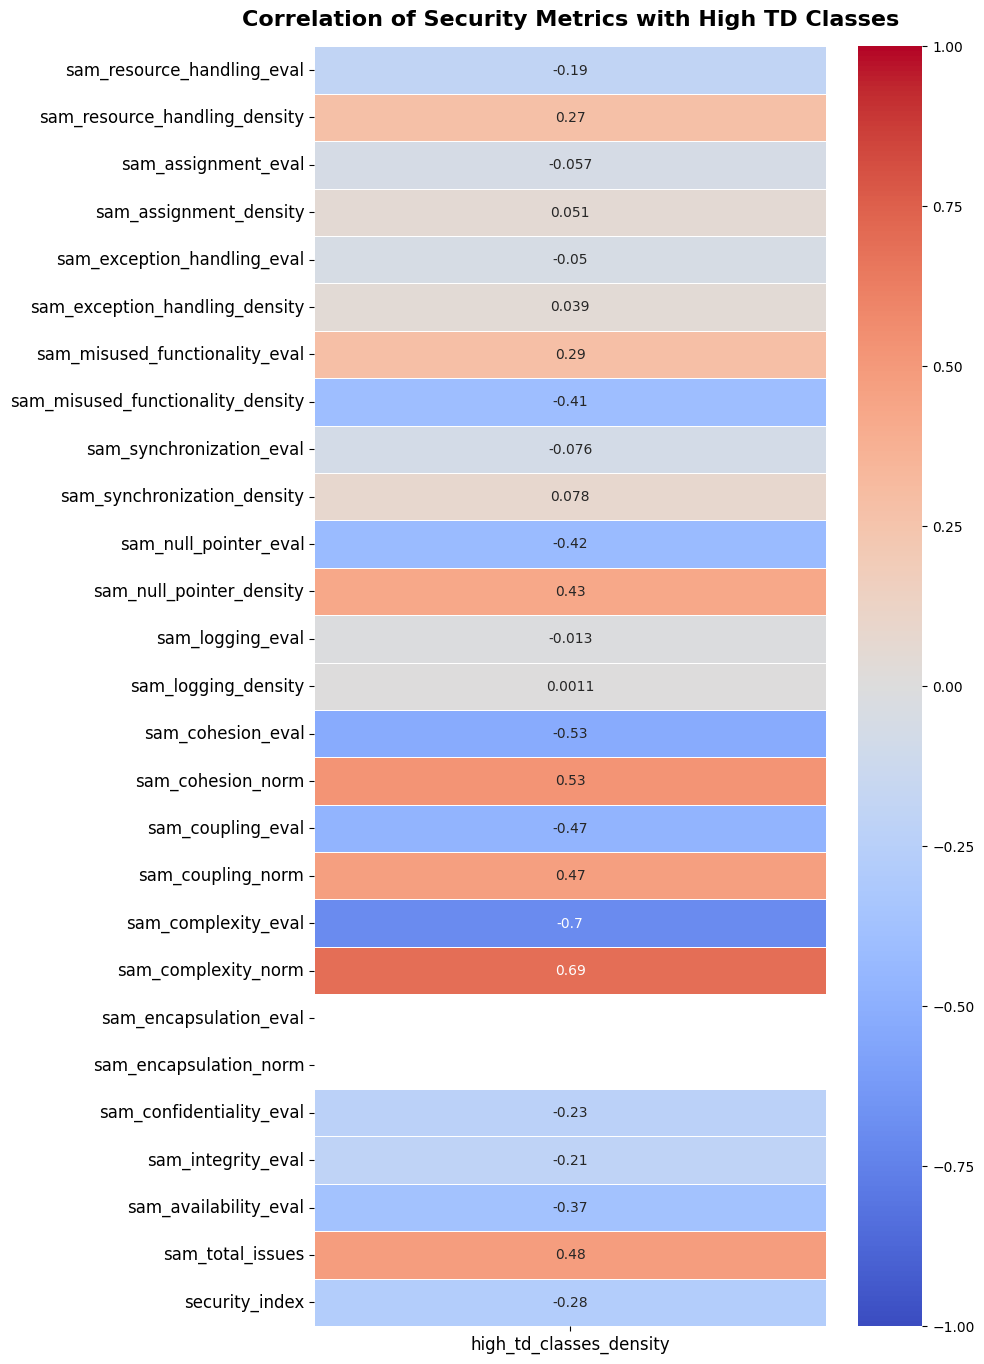

In [63]:
subset_corr_matrix = combined_corr_matrix.loc[security_columns, 'high_td_classes_density']
subset_corr_matrix = subset_corr_matrix.to_frame()

def plot_heatmap_with_annotations(matrix, title, vmin=-1, vmax=1):
    plt.figure(figsize=(10, 14))
    sns.heatmap(
        matrix,
        annot=True,
        cmap='coolwarm',
        vmin=vmin,
        vmax=vmax,
        center=0,
        linewidths=0.5,
        cbar=True,
        annot_kws={"size": 10}
    )
    plt.title(title, fontsize=16, weight='bold', pad=15)
    plt.yticks(rotation=0, fontsize=12)
    plt.xticks(fontsize=12)
    plt.tight_layout(pad=2.0)
    plt.show()

print("Subset Correlation Matrix:")
print(subset_corr_matrix)

plot_heatmap_with_annotations(subset_corr_matrix, 'Correlation of Security Metrics with High TD Classes')


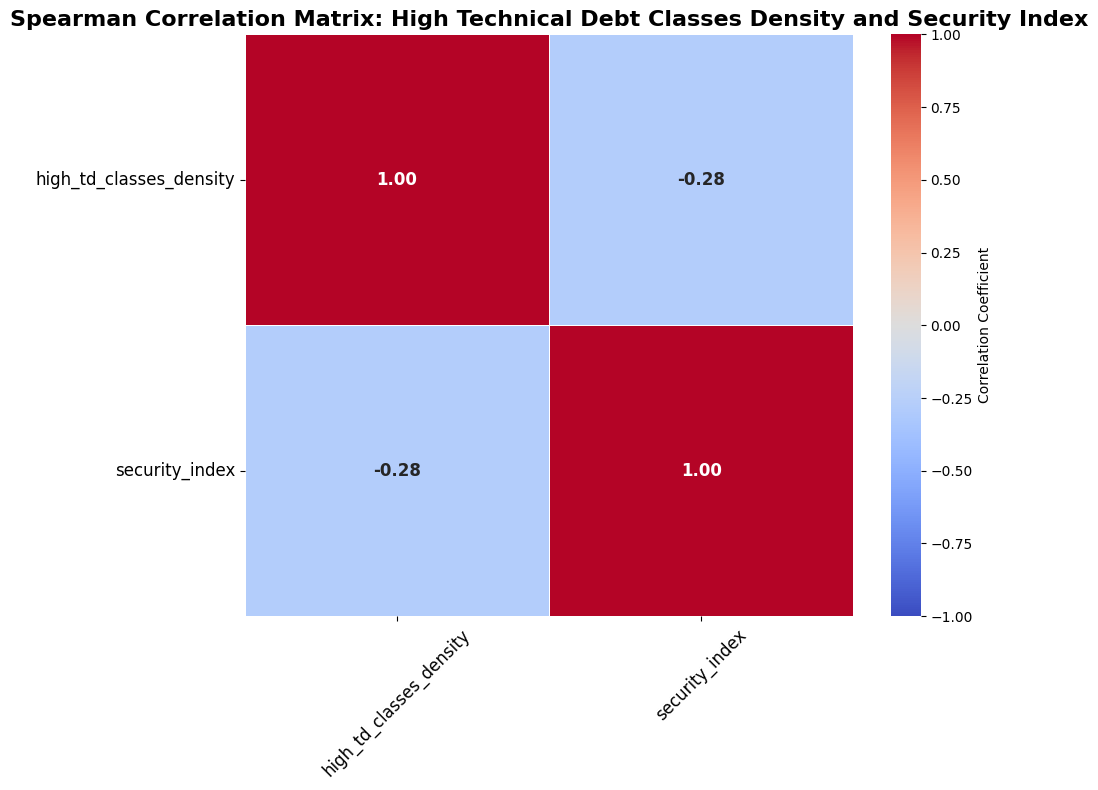

                         high_td_classes_density  security_index
high_td_classes_density                 1.000000       -0.277328
security_index                         -0.277328        1.000000


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = [
    'high_td_classes_density', 'security_index'
]

selected_df = merged_df[selected_columns]
selected_corr_matrix = selected_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(
    selected_corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'},
    annot_kws={'size': 12, 'weight': 'bold'},
)

plt.title('Spearman Correlation Matrix: High Technical Debt Classes Density and Security Index', fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

print(selected_corr_matrix)


In [65]:
print("Descriptive statistics for all columns")
print(merged_df.describe())

Descriptive statistics for all columns
              stars         cbo           wmc         dit         rfc  \
count    414.000000  414.000000    414.000000  414.000000  414.000000   
mean    1358.451691   16.620773    100.181159    2.466184   49.084541   
std     3975.442244   17.300748    827.794949   15.691566   48.105062   
min        0.000000    0.000000      1.000000    1.000000    0.000000   
25%       31.750000   10.000000     21.000000    1.000000   28.000000   
50%      149.000000   14.000000     37.000000    1.000000   41.500000   
75%      755.000000   19.000000     61.000000    2.000000   58.750000   
max    40307.000000  232.000000  16674.000000  319.000000  726.000000   

                lcom         npm       fanin      fanout         noc  ...  \
count     414.000000  414.000000  414.000000  414.000000  414.000000  ...   
mean     1508.755981   15.857488    3.997585   16.637681    0.070048  ...   
std     13009.010448   26.573148    3.127244   17.297402    0.504144  ..

Selected Feature: high_td_classes_density

Model where High TD Classes Density predicts Security Index:
Mean Squared Error: 0.0183
R-squared: 0.0373

Model where Security Index predicts High TD Classes Density:
Mean Squared Error: 0.0041
R-squared: 0.0226


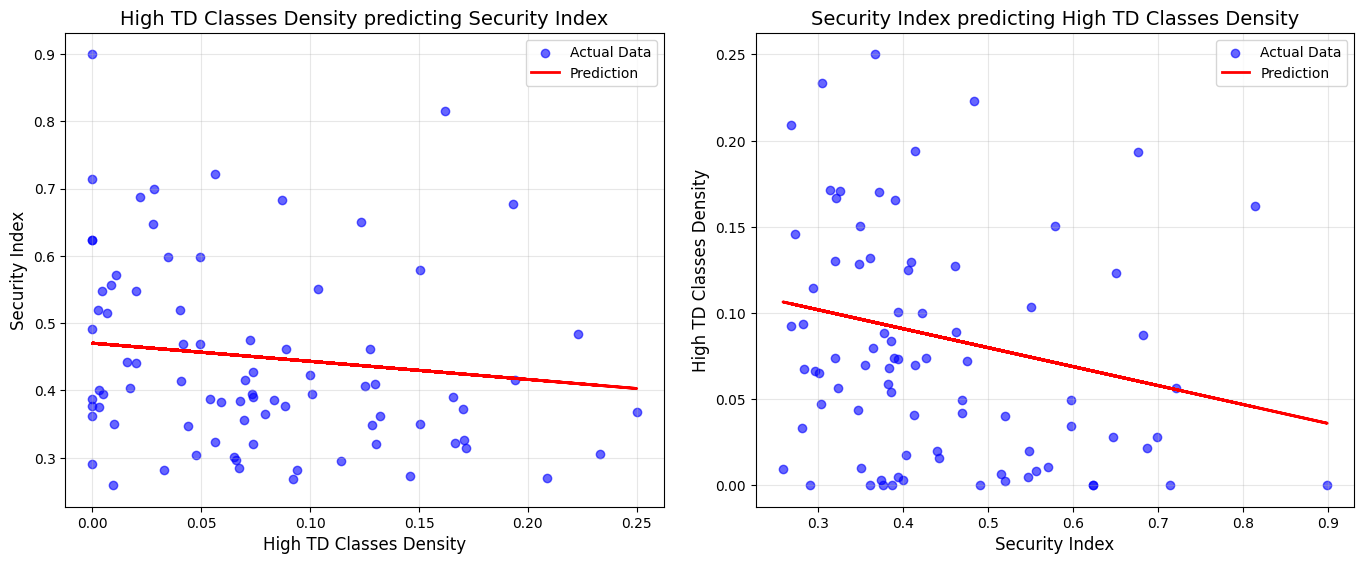

In [66]:
X = merged_df[['high_td_classes_density']]
y = merged_df['security_index']

selector = SelectKBest(f_regression, k=1)
selector.fit(X, y)

selected_feature = X.columns[selector.get_support()]
print("Selected Feature:", selected_feature[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_td_predicts_security = LinearRegression()
model_security_predicts_td = LinearRegression()

model_td_predicts_security.fit(X_train, y_train)
model_security_predicts_td.fit(y_train.values.reshape(-1, 1), X_train)

y_pred_td_to_security = model_td_predicts_security.predict(X_test)
y_pred_security_to_td = model_security_predicts_td.predict(y_test.values.reshape(-1, 1))

mse_td_to_security = mean_squared_error(y_test, y_pred_td_to_security)
r2_td_to_security = r2_score(y_test, y_pred_td_to_security)

mse_security_to_td = mean_squared_error(X_test, y_pred_security_to_td)
r2_security_to_td = r2_score(X_test, y_pred_security_to_td)

print("\nModel where High TD Classes Density predicts Security Index:")
print(f"Mean Squared Error: {mse_td_to_security:.4f}")
print(f"R-squared: {r2_td_to_security:.4f}")

print("\nModel where Security Index predicts High TD Classes Density:")
print(f"Mean Squared Error: {mse_security_to_td:.4f}")
print(f"R-squared: {r2_security_to_td:.4f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_test, y_test, color='blue', label='Actual Data', alpha=0.6)
plt.plot(X_test, y_pred_td_to_security, color='red', linewidth=2, label='Prediction')
plt.title('High TD Classes Density predicting Security Index', fontsize=14)
plt.xlabel('High TD Classes Density', fontsize=12)
plt.ylabel('Security Index', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, X_test, color='blue', label='Actual Data', alpha=0.6)
plt.plot(y_test, y_pred_security_to_td, color='red', linewidth=2, label='Prediction')
plt.title('Security Index predicting High TD Classes Density', fontsize=14)
plt.xlabel('Security Index', fontsize=12)
plt.ylabel('High TD Classes Density', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout(pad=2.0)
plt.show()


In [67]:
X = merged_df['high_td_classes_density']
y = merged_df['security_index']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

bp_test = het_breuschpagan(model.resid, model.model.exog)

print('\nBreusch-Pagan Test for Heteroscedasticity:')
print('Lagrange multiplier statistic:', bp_test[0])
print('p-value:', bp_test[1])
print('F-statistic:', bp_test[2])
print('p-value of F-statistic:', bp_test[3])

if bp_test[1] < 0.05:
    print('The Breusch-Pagan test suggests the presence of heteroscedasticity.')
else:
    print('The Breusch-Pagan test does not suggest the presence of heteroscedasticity.')


Breusch-Pagan Test for Heteroscedasticity:
Lagrange multiplier statistic: 1.4770118886622305
p-value: 0.22424262588781063
F-statistic: 1.475139363541616
p-value of F-statistic: 0.22523221861505152
The Breusch-Pagan test does not suggest the presence of heteroscedasticity.



Kendall's Tau Correlation:
Tau: -0.1954
p-value: 0.0000


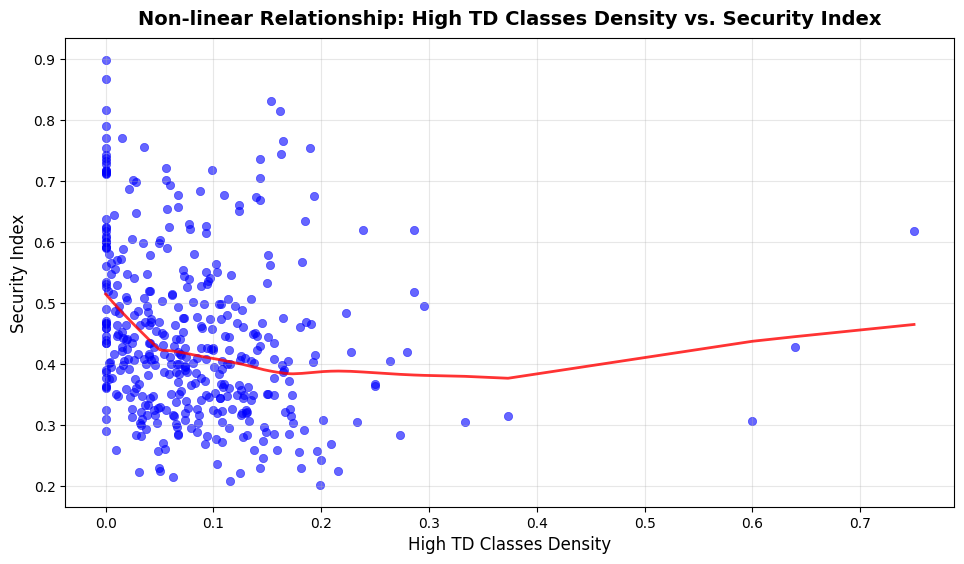

In [68]:
tau, p_value = kendalltau(merged_df['high_td_classes_density'], merged_df['security_index'])

print("\nKendall's Tau Correlation:")
print(f"Tau: {tau:.4f}")
print(f"p-value: {p_value:.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='high_td_classes_density',
    y='security_index',
    data=merged_df,
    alpha=0.6,
    color="blue",
    edgecolor=None
)
sns.regplot(
    x='high_td_classes_density',
    y='security_index',
    data=merged_df,
    lowess=True,
    scatter=False,
    color="red",
    line_kws={"linewidth": 2, "alpha": 0.8}
)
plt.title('Non-linear Relationship: High TD Classes Density vs. Security Index', fontsize=14, weight='bold', pad=10)
plt.xlabel('High TD Classes Density', fontsize=12)
plt.ylabel('Security Index', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout(pad=2.0)
plt.show()


In [69]:
for column in merged_df.columns:
  print(f"\nDescriptive Statistics for {column}:")
  print(merged_df[column].describe())
  print("-" * 30)


Descriptive Statistics for stars:
count      414.000000
mean      1358.451691
std       3975.442244
min          0.000000
25%         31.750000
50%        149.000000
75%        755.000000
max      40307.000000
Name: stars, dtype: float64
------------------------------

Descriptive Statistics for organization:
count        414
unique         6
top       apache
freq         217
Name: organization, dtype: object
------------------------------

Descriptive Statistics for project_name:
count           414
unique          413
top       cassandra
freq              2
Name: project_name, dtype: object
------------------------------

Descriptive Statistics for cbo:
count    414.000000
mean      16.620773
std       17.300748
min        0.000000
25%       10.000000
50%       14.000000
75%       19.000000
max      232.000000
Name: cbo, dtype: float64
------------------------------

Descriptive Statistics for wmc:
count      414.000000
mean       100.181159
std        827.794949
min          1.0000

In [70]:
def remove_outliers_iqr(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return data[(data >= lower_bound) & (data <= upper_bound)]

for column in merged_df.select_dtypes(include=np.number).columns:
  filtered_data = remove_outliers_iqr(merged_df[column])
  print(f"Column: {column}")
  print(f"Min without outliers: {filtered_data.min()}")
  print(f"Max without outliers: {filtered_data.max()}")
  print("-" * 30)

Column: stars
Min without outliers: 0
Max without outliers: 1589
------------------------------
Column: cbo
Min without outliers: 0
Max without outliers: 32
------------------------------
Column: wmc
Min without outliers: 1
Max without outliers: 116
------------------------------
Column: dit
Min without outliers: 1
Max without outliers: 3
------------------------------
Column: rfc
Min without outliers: 0
Max without outliers: 104
------------------------------
Column: lcom
Min without outliers: 0.0
Max without outliers: 1188.2409279734
------------------------------
Column: npm
Min without outliers: 0
Max without outliers: 34
------------------------------
Column: fanin
Min without outliers: 0
Max without outliers: 9
------------------------------
Column: fanout
Min without outliers: 0
Max without outliers: 32
------------------------------
Column: noc
Min without outliers: 0
Max without outliers: 0
------------------------------
Column: ncloc
Min without outliers: 21
Max without outli

In [71]:
numerical_df = merged_df.select_dtypes(include=np.number)
corr_matrix = numerical_df.corr(method='spearman')

corr_matrix = corr_matrix.mask(np.equal(*np.indices(corr_matrix.shape)))

correlation_pairs = corr_matrix.unstack()

sorted_correlations = correlation_pairs.sort_values(ascending=False)

high_correlation_threshold = 0.5
moderate_correlation_threshold = 0.3
low_correlation_threshold = 0.2

high_correlations = {}
moderate_correlations = {}
low_correlations = {}

for (var1, var2), correlation in sorted_correlations.items():
  if abs(correlation) >= high_correlation_threshold:
    if var1 not in high_correlations:
      high_correlations[var1] = []
    high_correlations[var1].append((var2, correlation))
  elif abs(correlation) >= moderate_correlation_threshold:
    if var1 not in moderate_correlations:
      moderate_correlations[var1] = []
    moderate_correlations[var1].append((var2, correlation))
  elif abs(correlation) >= low_correlation_threshold:
    if var1 not in low_correlations:
      low_correlations[var1] = []
    low_correlations[var1].append((var2, correlation))

print("High Correlations:")
for var, correlations in high_correlations.items():
  print(f"{var}:")
  for related_var, correlation_value in correlations:
    print(f"  - {related_var}: {correlation_value:.3f}")

print("\nModerate Correlations:")
for var, correlations in moderate_correlations.items():
  print(f"{var}:")
  for related_var, correlation_value in correlations:
    print(f"  - {related_var}: {correlation_value:.3f}")


print("\nLow Correlations:")
for var, correlations in low_correlations.items():
  print(f"{var}:")
  for related_var, correlation_value in correlations:
    print(f"  - {related_var}: {correlation_value:.3f}")


High Correlations:
cbo:
  - fanout: 1.000
  - sam_coupling_norm: 0.973
  - rfc: 0.771
  - wmc: 0.596
  - sam_total_issues: 0.548
  - npm: 0.546
  - sam_complexity_norm: 0.545
  - fanin: 0.533
  - high_td_classes: 0.530
  - ncloc: 0.526
  - lcom: 0.525
  - total_lines: 0.511
  - sam_complexity_eval: -0.548
  - sam_coupling_eval: -0.973
fanout:
  - cbo: 1.000
  - sam_coupling_norm: 0.972
  - rfc: 0.771
  - wmc: 0.596
  - sam_total_issues: 0.549
  - npm: 0.546
  - sam_complexity_norm: 0.545
  - fanin: 0.534
  - high_td_classes: 0.531
  - ncloc: 0.527
  - lcom: 0.524
  - total_lines: 0.512
  - sam_complexity_eval: -0.548
  - sam_coupling_eval: -0.972
ncloc:
  - total_lines: 0.997
  - sam_total_issues: 0.965
  - high_td_classes: 0.957
  - duplicated_lines: 0.930
  - lcom: 0.656
  - stars: 0.645
  - fanin: 0.598
  - sam_complexity_norm: 0.591
  - sam_cohesion_norm: 0.582
  - wmc: 0.580
  - npm: 0.561
  - sam_coupling_norm: 0.552
  - fanout: 0.527
  - cbo: 0.526
  - rfc: 0.503
  - sam_couplin

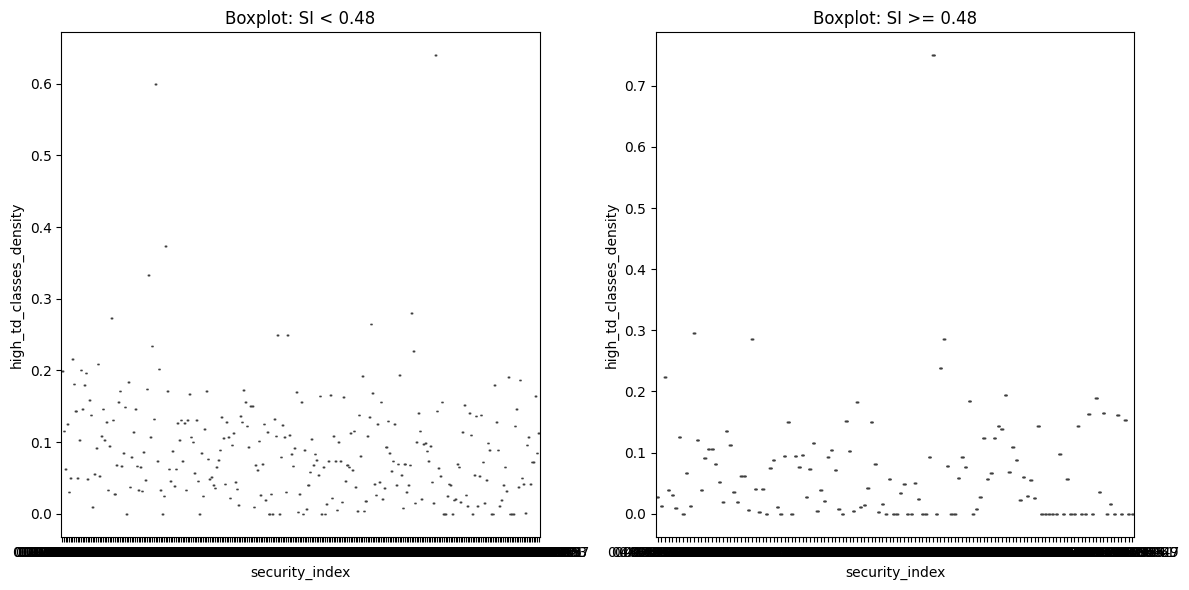

Spearman Correlation (SI < 0.48): -0.220
Spearman Correlation (SI >= 0.48): -0.143


In [72]:
df_lower = merged_df[merged_df['security_index'] < 0.48]
df_higher = merged_df[merged_df['security_index'] >= 0.48]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='security_index', y='high_td_classes_density', data=df_lower)
plt.title('Boxplot: SI < 0.48')
plt.subplot(1, 2, 2)
sns.boxplot(x='security_index', y='high_td_classes_density', data=df_higher)
plt.title('Boxplot: SI >= 0.48')
plt.tight_layout()
plt.show()


correlation_lower = df_lower['security_index'].corr(df_lower['high_td_classes_density'], method='spearman')
correlation_higher = df_higher['security_index'].corr(df_higher['high_td_classes_density'], method='spearman')

print(f"Spearman Correlation (SI < 0.48): {correlation_lower:.3f}")
print(f"Spearman Correlation (SI >= 0.48): {correlation_higher:.3f}")

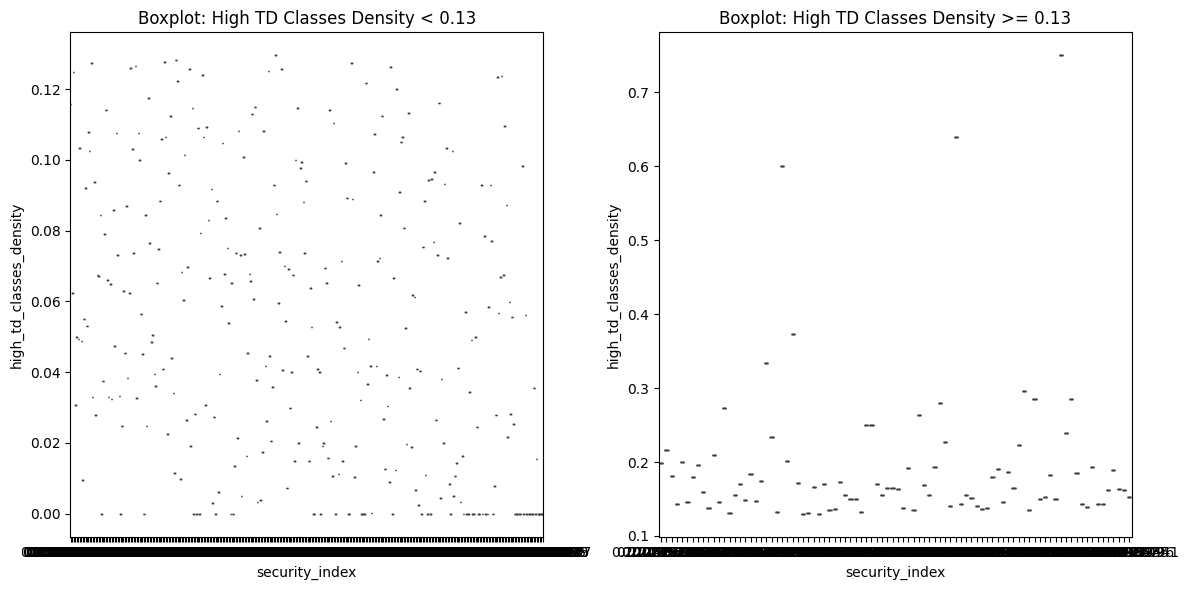

Spearman Correlation (High TD Classes Density < 0.13): -0.305
Spearman Correlation (High TD Classes Density >= 0.13): -0.015


In [73]:
df_lower_td = merged_df[merged_df['high_td_classes_density'] < 0.13]
df_higher_td = merged_df[merged_df['high_td_classes_density'] >= 0.13]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='security_index', y='high_td_classes_density', data=df_lower_td)
plt.title('Boxplot: High TD Classes Density < 0.13')
plt.subplot(1, 2, 2)
sns.boxplot(x='security_index', y='high_td_classes_density', data=df_higher_td)
plt.title('Boxplot: High TD Classes Density >= 0.13')
plt.tight_layout()
plt.show()

correlation_lower_td = df_lower_td['security_index'].corr(df_lower_td['high_td_classes_density'], method='spearman')
correlation_higher_td = df_higher_td['security_index'].corr(df_higher_td['high_td_classes_density'], method='spearman')

print(f"Spearman Correlation (High TD Classes Density < 0.13): {correlation_lower_td:.3f}")
print(f"Spearman Correlation (High TD Classes Density >= 0.13): {correlation_higher_td:.3f}")

In [74]:
def compare_correlation_coefficients(r1, n1, r2, n2):
  z1 = 0.5 * np.log((1 + r1) / (1 - r1))
  z2 = 0.5 * np.log((1 + r2) / (1 - r2))

  se_diff = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
  z = (z1 - z2) / se_diff
  p = 2 * (1 - stats.norm.cdf(abs(z)))
  return z, p

correlation_lower = df_lower['security_index'].corr(df_lower['high_td_classes_density'], method='spearman')
correlation_higher = df_higher['security_index'].corr(df_higher['high_td_classes_density'], method='spearman')
correlation_lower_td = df_lower_td['security_index'].corr(df_lower_td['high_td_classes_density'], method='spearman')
correlation_higher_td = df_higher_td['security_index'].corr(df_higher_td['high_td_classes_density'], method='spearman')

n_lower = len(df_lower)
n_higher = len(df_higher)
n_lower_td = len(df_lower_td)
n_higher_td = len(df_higher_td)

z_score, p_value = compare_correlation_coefficients(correlation_higher, n_higher, correlation_lower, n_lower)

print("\nComparison of Correlation Coefficients (Security Index Threshold):")
print(f"z-score: {z_score:.3f}")
print(f"p-value: {p_value:.4f}")

z_score_td, p_value_td = compare_correlation_coefficients(correlation_higher_td, n_higher_td, correlation_lower_td, n_lower_td)

print("\nComparison of Correlation Coefficients (High TD Classes Density Threshold):")
print(f"z-score: {z_score_td:.3f}")
print(f"p-value: {p_value_td:.4f}")

alpha = 0.05
if p_value < alpha:
  print("\nThe correlation coefficients between df_higher and df_lower are statistically significantly different.")
else:
  print("\nThe correlation coefficients between df_higher and df_lower are not statistically significantly different.")

if p_value_td < alpha:
  print("\nThe correlation coefficients between df_higher_td and df_lower_td are statistically significantly different.")
else:
  print("\nThe correlation coefficients between df_higher_td and df_lower_td are not statistically significantly different.")


Comparison of Correlation Coefficients (Security Index Threshold):
z-score: 0.757
p-value: 0.4491

Comparison of Correlation Coefficients (High TD Classes Density Threshold):
z-score: 2.487
p-value: 0.0129

The correlation coefficients between df_higher and df_lower are not statistically significantly different.

The correlation coefficients between df_higher_td and df_lower_td are statistically significantly different.


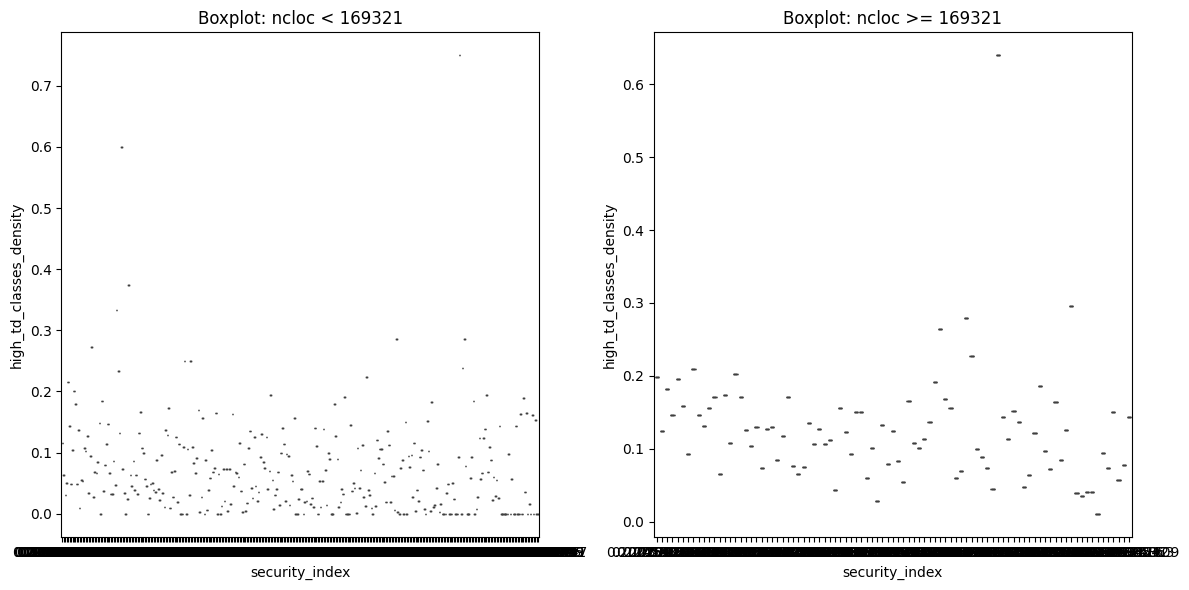

Spearman Correlation (ncloc < 169321): -0.217
Spearman Correlation (ncloc >= 169321): -0.305

Comparison of Correlation Coefficients (NCLOC Threshold)
z-score: -0.889
p-value: 0.3738

The correlation coefficients between df_higher_ncloc and df_lower_ncloc are not statistically significantly different.


In [75]:
df_lower_ncloc = merged_df[merged_df['ncloc'] < 169321]
df_higher_ncloc = merged_df[merged_df['ncloc'] >= 169321]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='security_index', y='high_td_classes_density', data=df_lower_ncloc)
plt.title('Boxplot: ncloc < 169321')
plt.subplot(1, 2, 2)
sns.boxplot(x='security_index', y='high_td_classes_density', data=df_higher_ncloc)
plt.title('Boxplot: ncloc >= 169321')
plt.tight_layout()
plt.show()

correlation_lower_ncloc = df_lower_ncloc['security_index'].corr(df_lower_ncloc['high_td_classes_density'], method='spearman')
correlation_higher_ncloc = df_higher_ncloc['security_index'].corr(df_higher_ncloc['high_td_classes_density'], method='spearman')

print(f"Spearman Correlation (ncloc < 169321): {correlation_lower_ncloc:.3f}")
print(f"Spearman Correlation (ncloc >= 169321): {correlation_higher_ncloc:.3f}")

z_score, p_value = compare_correlation_coefficients(correlation_higher_ncloc, n_higher, correlation_lower_ncloc, n_lower)

print("\nComparison of Correlation Coefficients (NCLOC Threshold)")
print(f"z-score: {z_score:.3f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
  print("\nThe correlation coefficients between df_higher_ncloc and df_lower_ncloc are statistically significantly different.")
else:
  print("\nThe correlation coefficients between df_higher_ncloc and df_lower_ncloc are not statistically significantly different.")

In [76]:
def compare_correlation_coefficients(r1, n1, r2, n2):
   z1 = 0.5 * np.log((1 + r1) / (1 - r1))
   z2 = 0.5 * np.log((1 + r2) / (1 - r2))

   se_diff = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
   z = (z1 - z2) / se_diff
   p = 2 * (1 - stats.norm.cdf(abs(z)))

   return z, p

correlation_lower = df_lower_ncloc['security_index'].corr(df_lower_ncloc['high_td_classes_density'], method='spearman')
correlation_higher = df_higher_ncloc['security_index'].corr(df_higher_ncloc['high_td_classes_density'], method='spearman')

n_lower = len(df_lower_ncloc)
n_higher = len(df_higher_ncloc)

z_score, p_value = compare_correlation_coefficients(correlation_higher, n_higher, correlation_lower, n_lower)

print("\nComparison of Correlation Coefficients (Security Index Threshold):")
print(f"z-score: {z_score:.3f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
  print("\nThe correlation coefficients between df_higher_ncloc and df_lower_ncloc are statistically significantly different.")
else:
  print("\nThe correlation coefficients between df_higher_ncloc and df_lower_ncloc are not statistically significantly different.")


Comparison of Correlation Coefficients (Security Index Threshold):
z-score: -0.787
p-value: 0.4315

The correlation coefficients between df_higher_ncloc and df_lower_ncloc are not statistically significantly different.
